In this post we will explore the most important parameters of Random Forest and how they impact our model in term of overfitting and underfitting.

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting.

We will use the Titanic Data from kaggle. For the sake of this post, we will perform as little feature engineering as possible as it is not the purpose of this post.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

Load train data

In [2]:
# get titanic & test csv files as a DataFrame
train = pd.read_csv("input/train.csv")
print train.shape

(891, 12)


In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Check for missing values

In [4]:
#Checking for missing data
NAs = pd.concat([train.isnull().sum()], axis=1, keys=['Train'])
NAs[NAs.sum(axis=1) > 0]

,Train
Age,177
Cabin,687
Embarked,2


We will remove 'Cabin', 'Name' and 'Ticket' columns as they require some processing to extract useful features

In [5]:
# At this point we will drop the Cabin feature since it is missing a lot of the data
train.pop('Cabin')

# At this point names don't affect our model so we drop it
train.pop('Name')

# At this point we drop Ticket feature
train.pop('Ticket')

train.shape

(891, 9)

Fill the missing age values by the mean value

In [6]:
# Filling missing Age values with mean
train['Age'] = train['Age'].fillna(train['Age'].mean())

Fill the missing 'Embarked' values by the most frequent value

In [7]:
# Filling missing Embarked values with most common value
train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode()[0])

In [8]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


'Pclass' is a categorical feature so we convert its values to strings

In [9]:
train['Pclass'] = train['Pclass'].apply(str)

Let's perform a basic one hot encoding of categorical features

In [10]:
# Getting Dummies from all other categorical vars
for col in train.dtypes[train.dtypes == 'object'].index:
    for_dummy = train.pop(col)
    train = pd.concat([train, pd.get_dummies(for_dummy, prefix=col)], axis=1)

In [11]:
train.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,22.0,1,0,7.2500,0,0,1,0,1,0,0,1
1,2,1,38.0,1,0,71.2833,1,0,0,1,0,1,0,0
2,3,1,26.0,0,0,7.9250,0,0,1,1,0,0,0,1
3,4,1,35.0,1,0,53.1000,1,0,0,1,0,0,0,1
4,5,0,35.0,0,0,8.0500,0,0,1,0,1,0,0,1


In [12]:
labels = train.pop('Survived')

For testing, we choose to split our data to 75% train and 25% for test

In [13]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train, labels, test_size=0.25)

Let's first fit a decision tree with default parameters to get a baseline idea of the performance

In [14]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

In [15]:
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [16]:
y_pred = rf.predict(x_test)

We will AUC (Area Under Curve) as the evaluation metric. Our target value is binary so it's a binary classification problem. AUC is a good way for evaluation for this type of problems

In [17]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.76481643356643347

## N_estimators

In [22]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]

In [23]:
train_results = []
test_results = []
for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    rf.fit(x_train, y_train)
    
    train_pred = rf.predict(x_train)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    y_pred = rf.predict(x_test)
    
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

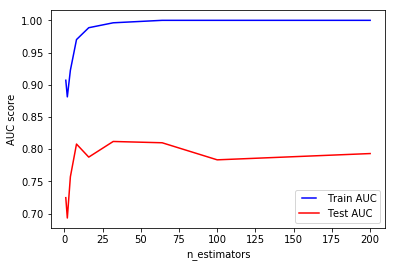

In [24]:
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

## max_depth

The first parameter to tune is max_depth. This indicates how deep the built tree can be. The deeper the tree, the more splits it has and it captures more information about how the data. We fit a decision tree with depths ranging from 1 to 32 and plot the training and test errors.

In [26]:
max_depths = np.linspace(1, 32, 32, endpoint=True)

In [28]:
train_results = []
test_results = []
for max_depth in max_depths:
    rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
    rf.fit(x_train, y_train)
    
    train_pred = rf.predict(x_train)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    y_pred = rf.predict(x_test)
    
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

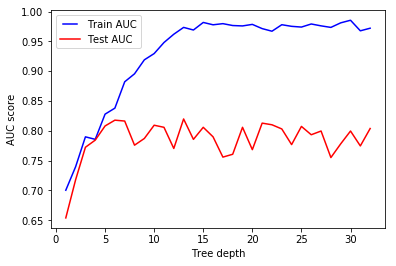

In [29]:
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

We see that our model overfits for large depth values. The tree perfectly predicts all of the train data, however, it fails to generalize the findings for new data

## min_samples_split

min_samples_split represents the minimum number of samples required to split an internal node. This can vary between considering at least one sample at each node to considering all of the samples at each node. When we increase this parameter, the tree becomes more constrained as it has to consider more samples at each node. Here we will vary the parameter from 10% to 100% of the samples

In [30]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)

In [31]:
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    rf = RandomForestClassifier(min_samples_split=min_samples_split)
    rf.fit(x_train, y_train)
    
    train_pred = rf.predict(x_train)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    y_pred = rf.predict(x_test)
    
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

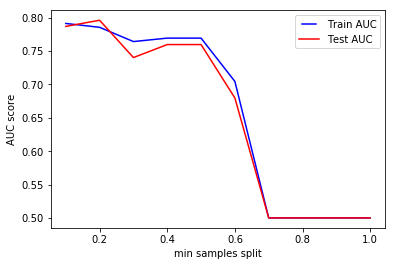

In [32]:
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

## min_samples_leaf 

min_samples_leaf is The minimum number of samples required to be at a leaf node. This similar to min_samples_splits, however, this describe the minimum number of samples of samples at the leafs.

In [33]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)

In [34]:
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    rf = RandomForestClassifier(min_samples_leaf=min_samples_leaf)
    rf.fit(x_train, y_train)
    
    train_pred = rf.predict(x_train)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    y_pred = rf.predict(x_test)
    
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

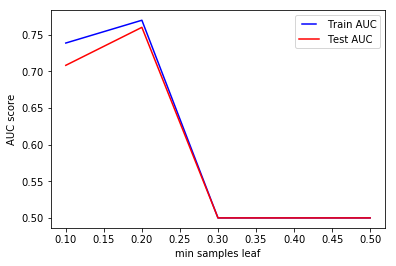

In [35]:
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

## max_features

max_features represents the number of features to consider when looking for the best split.

In [36]:
max_features = list(range(1,train.shape[1]))

In [37]:
train_results = []
test_results = []
for max_feature in max_features:
    rf = RandomForestClassifier(max_features=max_feature)
    rf.fit(x_train, y_train)
    
    train_pred = rf.predict(x_train)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    y_pred = rf.predict(x_test)
    
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

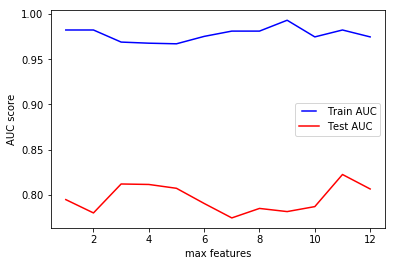

In [38]:
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(max_features, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_features, test_results, 'r', label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('max features')
plt.show()

According to sklearn documentation for decision tree, the search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than max_features features.